## 이미지 식별을 위한 라이브러리를 불러온다.

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 데이터 디렉토리, 분할 비율, 변환 방법을 설정한다.

In [39]:
data_dir = '../data'
valid_size = 0.2

t_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor()
])

### (확인) 변환 방법을 출력하여 확인해보기

In [40]:
print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


## 데이터 로더 함수 작성

### (연습) trainloader와 testloader를 만들어본다.

### 1. 학습 데이터  세트 및 테스트 데이터 세트의 디렉토리 및 변환 방식을 지정한다.

In [41]:
train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

print(train_data)

print(len(train_data), len(test_data))

Dataset ImageFolder
    Number of datapoints: 155
    Root location: ../data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
155 155


### 2. 데이터세트를 섞기 위해, 우선 인덱스를 만들어 랜덤하게 섞는다.

In [42]:
num_train = len(train_data)
indicies = list(range(num_train))
print(indicies)

np.random.shuffle(indicies)
print(indicies)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[23, 149, 79, 58, 54, 6, 132, 84, 71, 43, 109, 78, 57, 13, 4, 125, 41, 138, 123, 36, 44, 39, 15, 89, 96, 32, 77, 116, 100, 146, 55, 111, 8, 128, 31, 97, 76, 113, 2, 102, 129, 42, 137, 69, 61, 83, 88, 126, 9, 91, 81, 104, 101, 120, 34, 0, 127, 47, 30, 115, 118, 107, 136, 45, 94, 90, 51, 122, 152, 29, 65, 74, 7, 130, 73, 28, 87, 93, 1

### 3. 분할 비율(valid_size)에 따른 지점의 인덱스 값(split)을 계산한다.

In [43]:
split = int(np.floor(num_train * valid_size))
print(split)

31


### 4. split을 기준으로 학습 데이터 인덱스 리스트와 테스트 인덱스 리스트로 나눈다.

In [44]:
train_idx, test_idx = indicies[split:], indicies[:split]

print(train_idx)
print(test_idx)

[111, 8, 128, 31, 97, 76, 113, 2, 102, 129, 42, 137, 69, 61, 83, 88, 126, 9, 91, 81, 104, 101, 120, 34, 0, 127, 47, 30, 115, 118, 107, 136, 45, 94, 90, 51, 122, 152, 29, 65, 74, 7, 130, 73, 28, 87, 93, 141, 20, 68, 75, 25, 108, 38, 121, 11, 3, 70, 131, 40, 124, 1, 110, 92, 153, 133, 144, 114, 72, 147, 17, 145, 66, 142, 49, 63, 95, 119, 56, 67, 59, 12, 27, 134, 151, 46, 148, 10, 139, 52, 5, 105, 33, 154, 19, 14, 143, 99, 103, 112, 106, 22, 16, 18, 60, 26, 150, 48, 135, 140, 80, 21, 53, 62, 24, 50, 98, 85, 86, 64, 82, 117, 37, 35]
[23, 149, 79, 58, 54, 6, 132, 84, 71, 43, 109, 78, 57, 13, 4, 125, 41, 138, 123, 36, 44, 39, 15, 89, 96, 32, 77, 116, 100, 146, 55]


### 5. 데이터 세트들의 샘플러 및 로더를 만들고 확인한다.

In [45]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


### 코드들을 묶어서 load_split_train_test() 함수를 만든다.

In [46]:
def load_split_train_test(data_dir, valid_size):
    t_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor()
    ])

    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]
    from torch.utils.data.sampler import SubsetRandomSampler

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

### load_split_train_test() 함수를 이용하여 trainloader, testloader를 생성한다.

In [47]:
trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


### 이미지 데이터 샘플들을 살펴본다.

임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 get_random_images() 함수를 만든다.

In [48]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()

    return images, labels

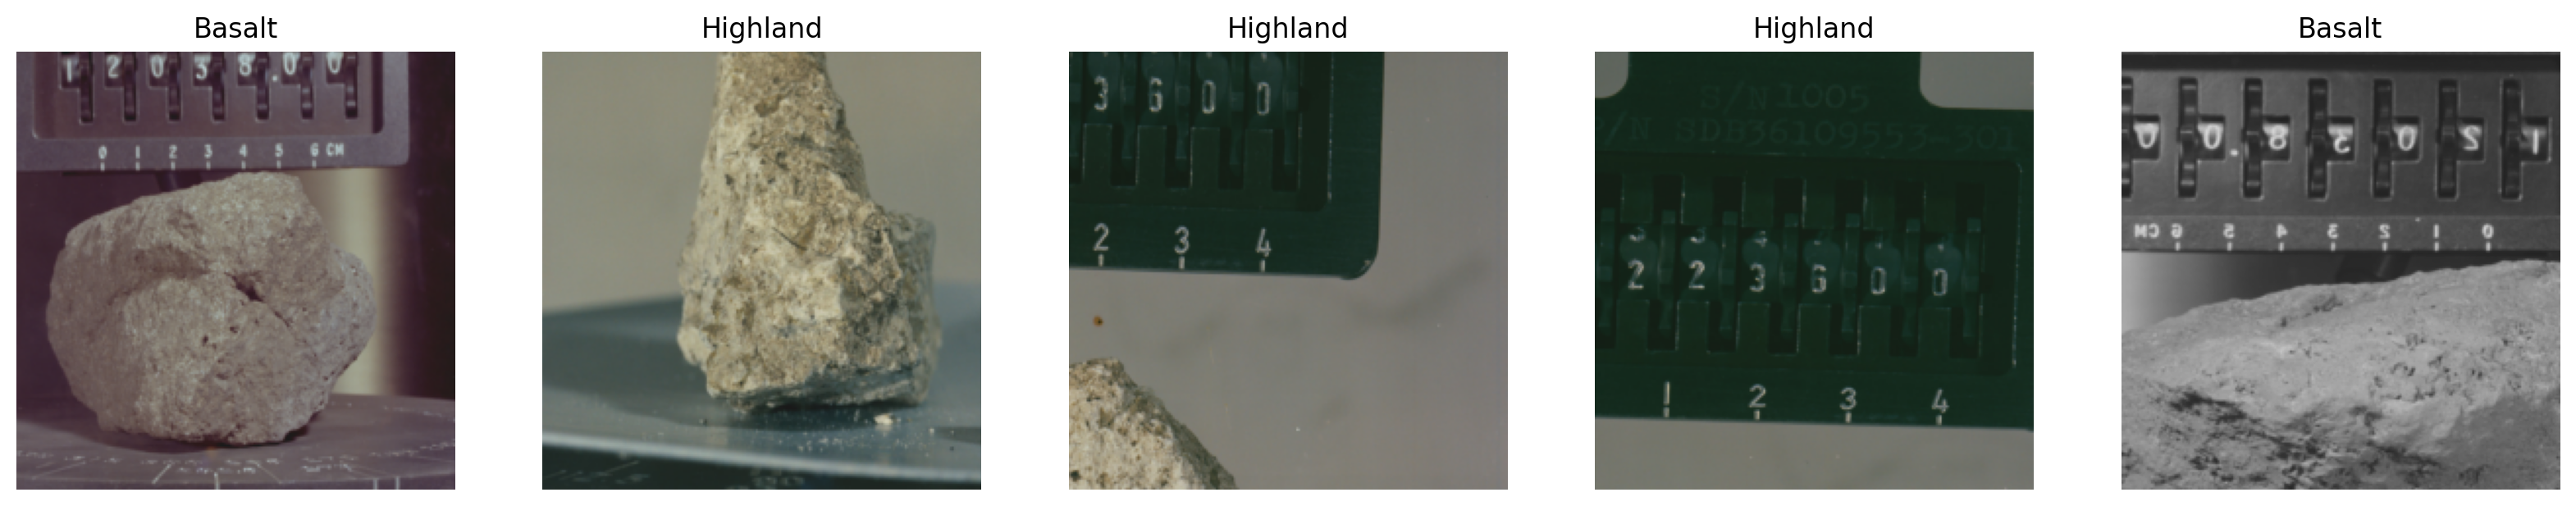

In [49]:
images, labels = get_random_images(5)
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))
classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
plt.show()

### ResNet50 모델을 가져와 FCL(Fully Connected Layer)을 수정한다.

Compute device를 정한다(CPU or GPU)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### 사전 학습된 ResNet50 모델을 지정한다.

In [51]:
model = models.resnet50(pretrained=True)

/workspaces/spacerokcs/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/workspaces/spacerokcs/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### (확인) 수정 전의 ResNet50 모델을 확인해 본다.

In [52]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 2),
                         nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print('done!')

done!


### (확인) FCL을 확인해 본다.

In [54]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


### 모델의 FCL을 학습시키고 테스트 한다.

모델 학습/검증을 위한 변수를 설정한다.

In [55]:
epochs = 10
print_every = 5
running_loss = 0
train_losses, test_losses = [], []
steps = 0

In [56]:
for epoch in range(epochs) :
    epoch += 1
    for inputs, labels in trainloader:
        steps += 1
        print('Training step ', steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            print("Epoch {}/{}: ".format(epoch, epochs),
                "Train loss: {:.3f}.. ".format(running_loss/print_every),
                "Test loss: {:.3f}.. ".format(test_loss/len(testloader)),
                "Test accuracy: {:.3f}\n".format(accuracy/len(testloader)))
            running_loss = 0
            model.train()
            break

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/10:  Train loss: 2.408..  Test loss: 1.724..  Test accuracy: 0.610

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/10:  Train loss: 1.282..  Test loss: 0.480..  Test accuracy: 0.746

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 3/10:  Train loss: 0.661..  Test loss: 1.213..  Test accuracy: 0.421

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 4/10:  Train loss: 0.469..  Test loss: 0.463..  Test accuracy: 0.775

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 5/10:  Train loss: 0.358..  Test loss: 0.303..  Test accuracy: 0.871

Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 6/10:  Train loss: 0.285..  Test loss: 0.229..  Test accuracy: 0.902

Training step

### (확인) 학습 손실값과 테스트 손실값을 그래프로 확인한다.

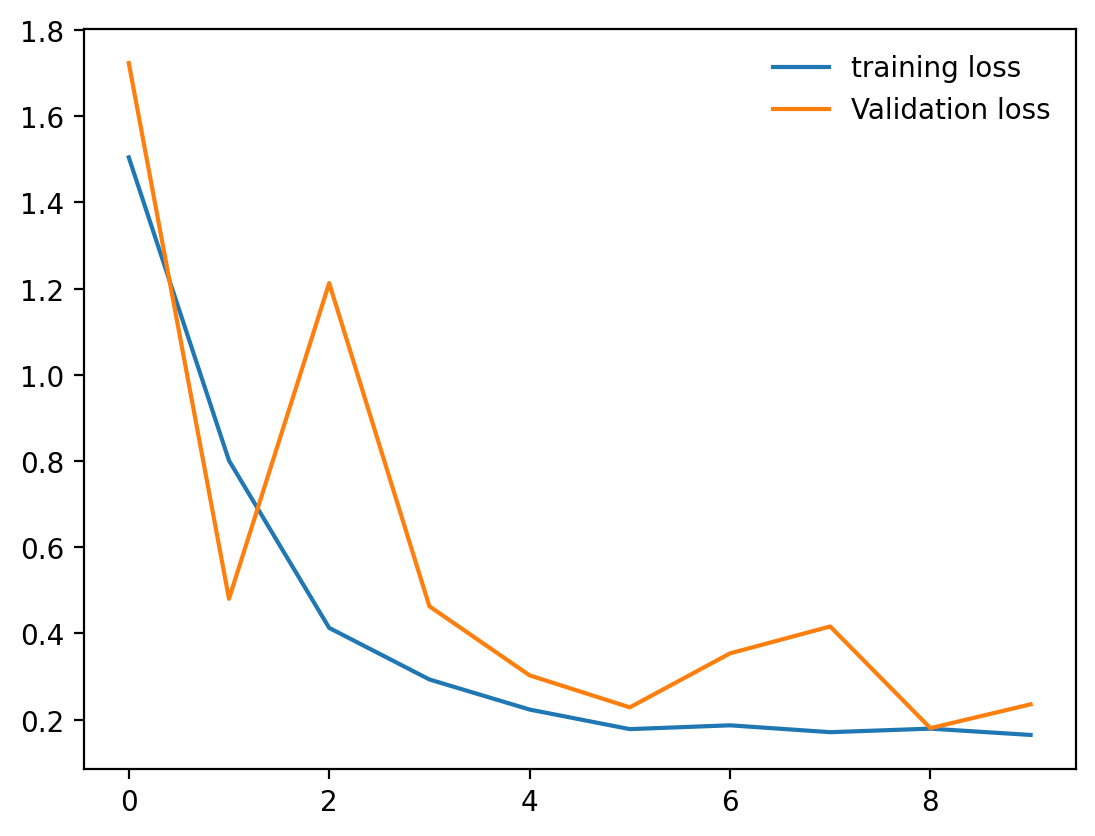

In [57]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### 학습/테스트 완료된 모델을 저장한다.

In [58]:
torch.save(model, 'moonrockmodel.pth')

### 완성된 모델을 사용하여 예측한다.

저장한 모델을 불러온다.

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('moonrockmodel.pth')

### (확인) 불러온 모델을 확인해 본다.

In [60]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 이미지 예측을 위해 predict_image() 함수를 만든다.

In [61]:
def predict_image(image):
    image_tensor = t_transforms(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.numpy().argmax()

    return index

### 5개의 이미지를 임의로 가져와 예측해 본다.

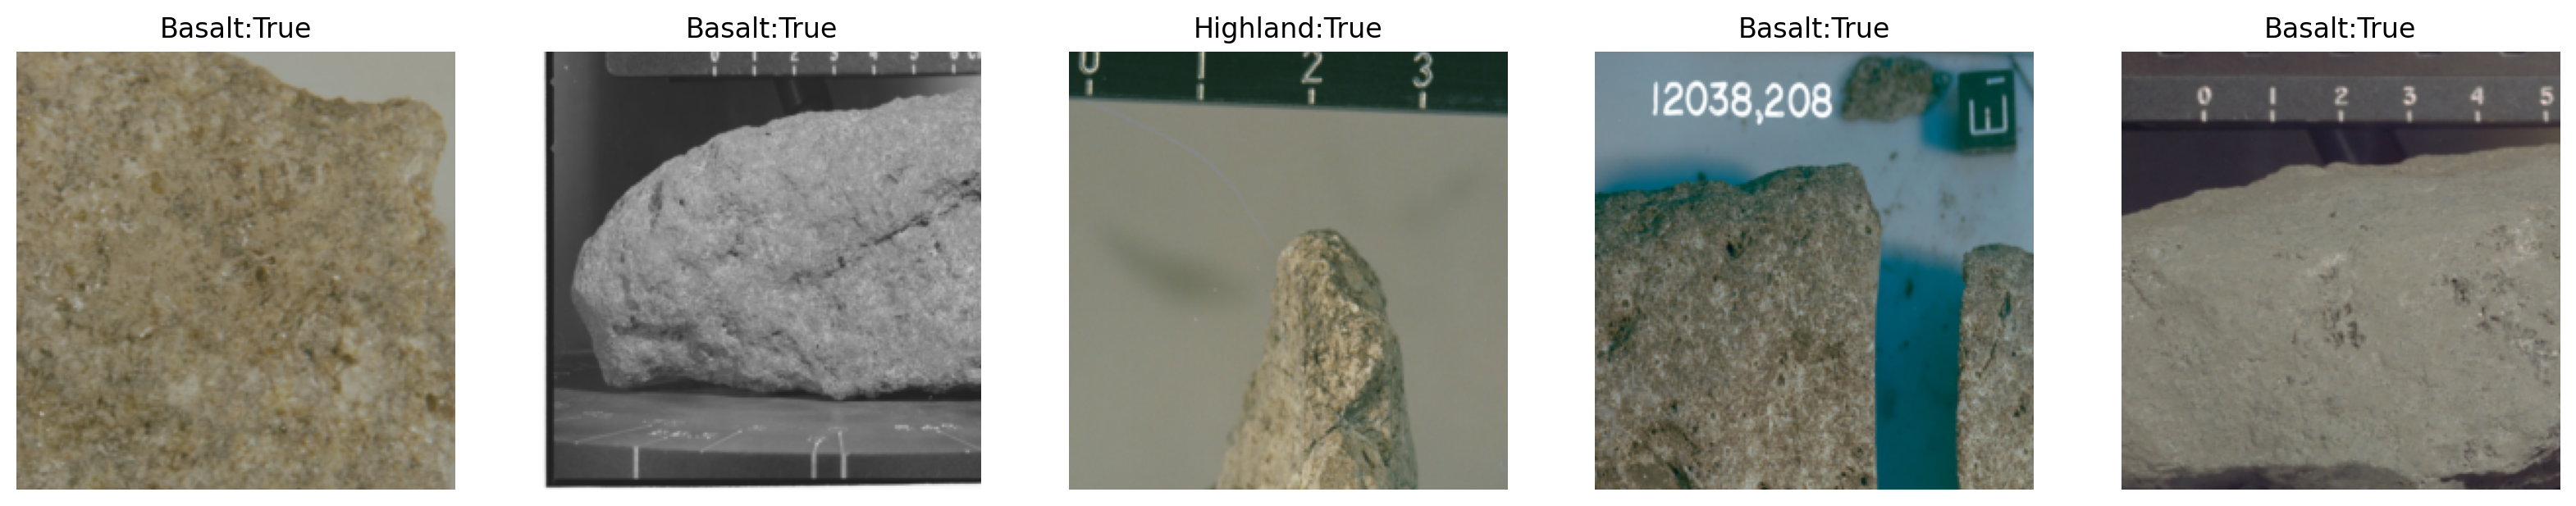

In [63]:
model.eval()

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20, 20))
classes = trainloader.dataset.classes

for ii in range(len(images)):
    image = to_pil(images[ii])
    index= predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = labels[ii].item() == index
    sub.set_title(classes[index] + ':' + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()